In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


#from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [2]:
def ang_to_mollweide(phi,theta):
    x=phi/np.pi*np.sqrt(1-(theta/(np.pi/2))**2)
    y=theta/(np.pi)
    return x,y

In [3]:
def rand_sphere(npt):
    phi=np.random.uniform(-np.pi,np.pi,npt)
    theta=np.arccos(np.random.uniform(-1,1,npt))-np.pi/2
    return phi,theta

In [4]:
def init_dof(npt):
    positions=rand_sphere(npt)
    return positions,np.zeros_like(positions)

In [46]:
plt.style.use('dark_background')
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.axis("equal")
ax.axis(False)


randoms=rand_sphere(1000)
rands_moll=ang_to_mollweide(randoms[0],randoms[1])
ax.plot(rands_moll[0],rands_moll[1],".",color="white",markersize=1)

x=np.linspace(-1,1,1001)
contour=np.sqrt(1-x**2)/2
ax.plot(x,contour,x,-contour,color="white",linewidth=0.5)



plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
def ang_to_xyz(phi,theta):
    x = np.sin(theta+np.pi/2)*np.cos(phi)
    y = np.sin(theta+np.pi/2)*np.sin(phi)
    z = np.cos(theta+np.pi/2)
    return x,y,z

In [29]:
plt.style.use('dark_background')
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

x,y,z=ang_to_xyz(randoms[0],randoms[1])


ax.scatter(x, y, z, marker=".")

ax.axis(False)
ax.set_box_aspect([1,1,1])

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
def g_at_pos(pos, particles, mass, epsilon=1.0, doimages=True):
    # eqn. (10) of http://www.skiesanduniverses.org/resources/KlypinNbody.pdf.
    # Here epsilon is a fudge factor to stop a blow up of the gravitational force at zero distance.
    
    delta_r = particles - pos
    result  = mass * np.sum(delta_r / (delta_r**2. + epsilon**2.)**(3./2.), axis=0)
    
    # If 'pos' is one of the particles, then technically we've including the "self-force"
    # But such a pos will have delta_r = 0, and thus contribute nothing to the total force, as it should!

    if doimages:
        # Our simulation assumes periodic boundary conditions, so for the acceleration of each particle, there's a 
        # corresponding acceleration due to the image of the particle produced by applying periodic shifts to its
        # position.
        shift  = np.array([-1, 0, 1])
        images = []

        for triple in itertools.product(shift, repeat=3):
            images.append(triple)
    
        images.remove((0, 0, 0))
    
        images = np.array(images)
    
        for image in images:
            delta_r_displaced = delta_r + image
            result += mass * np.sum(delta_r_displaced / (delta_r_displaced**2. + epsilon**2.)**(3./2.), axis=0)

    return  result

In [ ]:
# We'll sample the equations of motion in discrete time steps. 
dt         = 5e-4
nsteps     = 500
timesteps  = np.linspace(0, (nsteps)*dt, nsteps, endpoint=False)

# Number and mass of particles
npt        = 50
mass       = 0.25

# Whether to draw arrows for the acceleration and velocity
draw_acc   = False
draw_vel   = False

# A small drag term to simulate the real drag dark matter particles experience due to the expanding universe
drag = 1e-2

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)

ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)

# Reinitialise particles.
pos, vel = init_dof(npt=npt)


for index_in_timestep, time in enumerate(timesteps):
    ax.clear()

    ax.set_title(f'N-body simulation with $N={npt}$ particles')
    step_label = ax.text(0.03, .97, f'Step {index_in_timestep}',
            transform=ax.transAxes, verticalalignment='top', c='k',
            bbox=dict(color='w', alpha=0.8))

    dvel                        = np.zeros_like(vel)
    dpos                        = np.zeros_like(pos)
    acc                         = np.zeros_like(pos)

    for index_in_particle in range(npt):
        acc[index_in_particle]  = g_at_pos(pos[index_in_particle], pos, mass, epsilon=0.1)

        # Update velocities. 
        dvel[index_in_particle] = dt * acc[index_in_particle]

        # Update positions.
        dpos[index_in_particle] = dt * vel[index_in_particle]           

    vel += dvel - drag*vel
    pos += dpos

    # Our simulation has periodic boundaries, if you go off one side you come back on the other!
    pos = pos % 1.

    ax.scatter(pos[:,0], pos[:,1], color='darkorange', edgecolor='w')

In [39]:
plt.style.use('dark_background')
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

# Make data
sphere_resol=100

phi = np.linspace(0,2*np.pi,sphere_resol)
theta = np.linspace(0,np.pi,sphere_resol)


x = np.outer(np.sin(theta),np.cos(phi))
y = np.outer(np.sin(theta),np.sin(phi))
z = np.outer(np.cos(theta),np.ones(sphere_resol))

ax.plot_surface(x, y, z, color='white',alpha=0.5)

ax.axis(False)

ax.set_box_aspect([1,1,1])

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

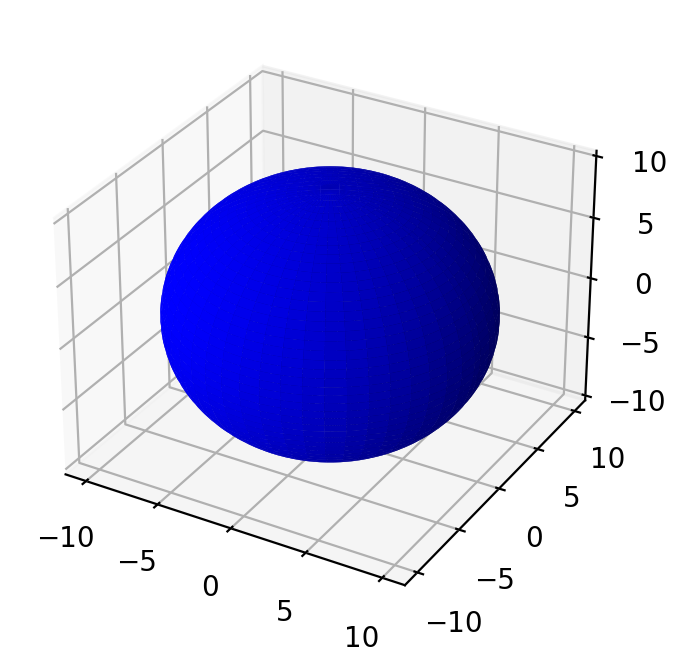

In [8]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 10 * np.outer(np.cos(u), np.sin(v))
y = 10 * np.outer(np.sin(u), np.sin(v))
z = 10 * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, color='b')
plt.show()